In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Environment():
    def __init__(self,n_arms, probabilities):
        self.narms = n_arms
        self.probabilites = probabilities

    def round(self, pulled_arm):
        reward= np.random.binomial(1, self.probabilites[pulled_arm])
        return reward

In [3]:
class Non_Stationary_environment(Environment):
    def __init__(self, n_arms, probabilities, horizon):
        super().__init__(n_arms, probabilities)
        self.t = 0
        n_phases = len(self.probabilites)
        self.phases_size = horizon/n_phases

    def round(self, pulled_arm):
        current_phases = int(self.t / self.phases_size)
        p = self.probabilites[current_phases][pulled_arm]
        reward = np.random.binomial(1,p)
        self.t += 1
        return reward

In [4]:
class Learner:

    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0
        self.reward_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observation(self, pulled_arm, reward):
        self.reward_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards,reward)

In [5]:
class Greedy_Learner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.expected_rewards = np.zeros(n_arms)

    def pull_arm(self):
        if(self.t<self.n_arms):
            return self.t
        idxs = np.argwhere(self.expected_rewards == self.expected_rewards.max()).reshape(-1)
        pulled_arm = np.random.choice(idxs)
        return pulled_arm

    def update(self, pulled_arm, reward):
        self.t+=1
        self.update_observation(pulled_arm, reward)
        self.expected_rewards[pulled_arm] = (self.expected_rewards[pulled_arm]*(self.t - 1) + reward) / self.t

In [6]:
class TS_Learner(Learner):
    def __init__(self,n_arms):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms,2))

    def pull_arm(self):
        idx = np.argmax(np.random.beta(self.beta_parameters[:,0], self.beta_parameters[:,1]))
        return idx

    def update(self, pulled_arm, reward):
        self.t+=1
        self.update_observation(pulled_arm, reward)
        self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
        self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1.0 - reward

In [7]:
class SWTS_Learner(TS_Learner):
    def __init__(self, n_arms, window_size):
        super().__init__(n_arms)
        self.window_size = window_size
        self.pulled_arms = np.array([])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observation(pulled_arm, reward)
        self.pulled_arms = np.append(self.pulled_arms, pulled_arm)
        for arm in range(self.n_arms):
            n_samples = np.sum(self.pulled_arms[-self.window_size:] == arm)
            cum_rew = np.sum(self.reward_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
            self.beta_parameters[arm, 0] = cum_rew + 1.0
            self.beta_parameters[arm, 1] = n_samples - cum_rew + 1

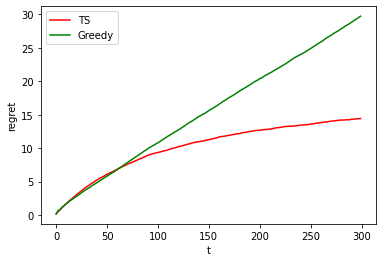

In [8]:
n_arms = 4
p = np.array([0.15, 0.1, 0.1, 0.35])
opt = p[3]

T = 300

n_experiments = 1000
ts_rewards_per_experiment = []
gr_rewards_per_experiment = []


for e in range(0,n_experiments):
    env = Environment(n_arms = n_arms, probabilities=p)
    ts_learner = TS_Learner(n_arms = n_arms)
    gr_learner = Greedy_Learner(n_arms=n_arms)
    for t in range(0,T):
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)

        pulled_arm = gr_learner.pull_arm()
        reward = env.round(pulled_arm)
        gr_learner.update(pulled_arm, reward)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    gr_rewards_per_experiment.append(gr_learner.collected_rewards)


plt.figure(0)
plt.xlabel("t")
plt.ylabel("regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.legend(["TS", "Greedy"])
plt.show()

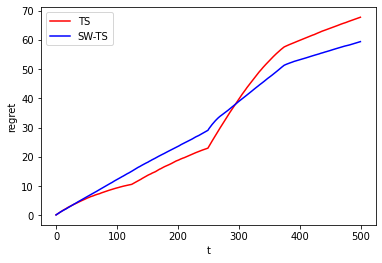

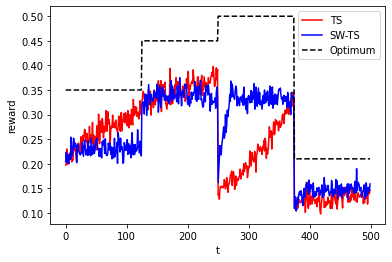

In [9]:
n_arms = 4
n_phases = 4 

p = np.array([[0.15, 0.1, 0.2, 0.35],
              [0.45, 0.21, 0.2, 0.35],
              [0.1, 0.1, 0.5, 0.15],
              [0.1, 0.21, 0.1, 0.15]])

T = 500
phases_len = int(T/n_phases)
n_experiments = 1000
ts_rewards_per_experiment = []
swts_rewards_per_experiment = []
windw_size = int(T**0.5)

if __name__ == '__main__':

    for e in range(n_experiments):
        ts_env = Non_Stationary_environment(n_arms, probabilities=p, horizon=T)
        ts_learner = TS_Learner(n_arms=n_arms)

        swts_env = Non_Stationary_environment(n_arms, probabilities=p, horizon=T)
        swts_learner = SWTS_Learner(n_arms=n_arms, window_size=windw_size)

        for t in range(T):
            pulled_arm = ts_learner.pull_arm()
            reward = ts_env.round(pulled_arm)
            ts_learner.update(pulled_arm, reward)

            pulled_arm = swts_learner.pull_arm()
            reward = swts_env.round(pulled_arm)
            swts_learner.update(pulled_arm, reward)

        ts_rewards_per_experiment.append(ts_learner.collected_rewards)
        swts_rewards_per_experiment.append(swts_learner.collected_rewards)

    ts_instantaneus_regret = np.zeros(T)
    swts_instantaneus_regret = np.zeros(T)
    opt_per_phases = p.max(axis=1)
    optimum_per_round = np.zeros(T)

    for i in range(n_phases):
        t_index = range(i*phases_len, (i+1)*phases_len)
        optimum_per_round[t_index] = opt_per_phases[i]
        ts_instantaneus_regret[t_index] = opt_per_phases[i] - np.mean(ts_rewards_per_experiment, axis=0)[t_index]
        swts_instantaneus_regret[t_index] = opt_per_phases[i] - np.mean(swts_rewards_per_experiment, axis=0)[t_index]


    plt.figure(0)
    plt.plot(np.cumsum(ts_instantaneus_regret), 'r')
    plt.plot(np.cumsum(swts_instantaneus_regret), 'b')
    plt.legend(['TS', 'SW-TS'])
    plt.ylabel('regret')
    plt.xlabel('t')
    plt.show()

    plt.figure(1)
    plt.plot(np.mean(ts_rewards_per_experiment, axis=0), 'r')
    plt.plot(np.mean(swts_rewards_per_experiment, axis=0), 'b')
    plt.plot(optimum_per_round, 'k--')
    plt.legend(['TS', 'SW-TS', 'Optimum'])
    plt.ylabel('reward')
    plt.xlabel('t')
    plt.show()